In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from glob import glob
from moviepy.editor import VideoFileClip
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

  if event.key is 'enter':



In [3]:
# Configuración
FRAME_COUNT = 16  # Número de frames a extraer por vídeo
IMG_SIZE = 224  # Tamaño de imagen
BATCH_SIZE = 8
EPOCHS = 10
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
import torchvision.transforms as transforms
from PIL import Image

# Transformaciones para entrenamiento (Data Augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar
    transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontal aleatorio
    transforms.RandomRotation(15),  # Rotación aleatoria hasta ±15 grados
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Pequeños desplazamientos
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Variar brillo y contraste
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalización para imágenes en escala de grises
])

# Transformaciones para validación (sin augmentación)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [5]:
from PIL import Image
def extract_frames(video_path, num_frames=16, train=True):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames < num_frames:
        frame_ids = np.linspace(0, total_frames - 1, total_frames, dtype=int)  # Tomar todos los disponibles
    else:
        frame_ids = np.linspace(0, total_frames - 1, num_frames, dtype=int)  # Frames espaciados uniformemente

    for fid in frame_ids:
        cap.set(cv2.CAP_PROP_POS_FRAMES, fid)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convertir a blanco y negro
            frame = Image.fromarray(frame)  # Convertir de NumPy a PIL Image

            # Aplicar transformaciones de torchvision
            transform = train_transforms if train else val_transforms
            frame = transform(frame)  # Aplicar transformaciones

            frames.append(frame)

    cap.release()

    if len(frames) < num_frames:
        frames.extend([frames[-1]] * (num_frames - len(frames)))  # Padding con último frame

    return torch.stack(frames)  # (16, 1, 224, 224)

In [ ]:
# # Función para extraer frames de un vídeo (COLOR)
# def extract_frames(video_path, num_frames=FRAME_COUNT):
#     cap = cv2.VideoCapture(video_path)
#     frames = []
#     total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#     frame_ids = np.linspace(0, total_frames - 1, num_frames, dtype=int)
#     for fid in frame_ids:
#         cap.set(cv2.CAP_PROP_POS_FRAMES, fid)
#         ret, frame = cap.read()
#         if ret:
#             frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
#             frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#             frames.append(frame)
#     cap.release()
#     if len(frames) < num_frames:
#         frames.extend([frames[-1]] * (num_frames - len(frames)))  # Padding con último frame
#     return np.array(frames)

In [6]:
import random

DATASET_PATH = "/content/drive/MyDrive/MASTER IA/RNN Entrega/Dataset"

# Diccionario para almacenar videos seleccionados por categoría
selected_videos = {}


# Recorremos las subcarpetas dentro de dataset (una por cada deporte)
for sport in os.listdir(DATASET_PATH):
    sport_path = os.path.join(DATASET_PATH, sport)

    if os.path.isdir(sport_path):  # Nos aseguramos de que sea una carpeta
        video_files = glob(os.path.join(sport_path, "*"))  # Busca vídeos en la carpeta
        if len(video_files) >= 7:
            selected_videos[sport] = random.sample(video_files, 7)  # Selecciona 4 aleatorios
        else:
            print(f"⚠️ La categoría '{sport}' tiene menos de 4 vídeos.")

# Mostramos los videos seleccionados
for sport, videos in selected_videos.items():
    print(f"Deporte: {sport}, Videos seleccionados: {videos}")



Deporte: Kayaking, Videos seleccionados: ['/content/drive/MyDrive/MASTER IA/RNN Entrega/Dataset/Kayaking/v_Kayaking_g16_c04.avi', '/content/drive/MyDrive/MASTER IA/RNN Entrega/Dataset/Kayaking/v_Kayaking_g24_c03.avi', '/content/drive/MyDrive/MASTER IA/RNN Entrega/Dataset/Kayaking/v_Kayaking_g15_c06.avi', '/content/drive/MyDrive/MASTER IA/RNN Entrega/Dataset/Kayaking/v_Kayaking_g12_c02.avi', '/content/drive/MyDrive/MASTER IA/RNN Entrega/Dataset/Kayaking/v_Kayaking_g18_c06.avi', '/content/drive/MyDrive/MASTER IA/RNN Entrega/Dataset/Kayaking/v_Kayaking_g09_c05.avi', '/content/drive/MyDrive/MASTER IA/RNN Entrega/Dataset/Kayaking/v_Kayaking_g20_c04.avi']
Deporte: Biking, Videos seleccionados: ['/content/drive/MyDrive/MASTER IA/RNN Entrega/Dataset/Biking/v_Biking_g21_c02.avi', '/content/drive/MyDrive/MASTER IA/RNN Entrega/Dataset/Biking/v_Biking_g10_c04.avi', '/content/drive/MyDrive/MASTER IA/RNN Entrega/Dataset/Biking/v_Biking_g06_c03.avi', '/content/drive/MyDrive/MASTER IA/RNN Entrega/Data

In [9]:
class CustomDataset(Dataset):
    def __init__(self, video_dict, train=True):
        self.video_paths = list(video_dict.keys())  # Lista de rutas de vídeo
        self.labels = list(video_dict.values())  # Lista de etiquetas numéricas
        self.train = train  # Indica si aplicar augmentación o no

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        # Extraer frames con augmentación solo si estamos en entrenamiento
        frames = extract_frames(video_path, num_frames=16, train=self.train)

        # # Extraer frames del vídeo
        # frames = extract_frames(video_path, num_frames=16)

        # # Convertir a tensor de PyTorch y asegurarse de que está en el formato correcto
        # frames = torch.tensor(frames, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0  # (16, 1, 224, 224)

        return frames, label

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

BATCH_SIZE = 2

# Extraer rutas de vídeos y sus etiquetas
video_paths = []
labels = []
print("Clases en selected_videos:", selected_videos.keys())
label_map = {sport: idx for idx, sport in enumerate(selected_videos.keys())}
print("Label map actualizado:", label_map)
for sport, videos in selected_videos.items():
    for video in videos:
        video_paths.append(video)
        labels.append(label_map[sport])  # Convertir a índice numérico
print(len(video_paths))
print(len(labels))
# División estratificada para asegurar representación de todas las clases
X_train, X_test, y_train, y_test = train_test_split(video_paths, labels, test_size=0.3, stratify=labels, random_state=42)

# Crear datasets
train_videos = {X_train[i]: y_train[i] for i in range(len(X_train))}
test_videos = {X_test[i]: y_test[i] for i in range(len(X_test))}
print(train_videos)
print(test_videos)
train_dataset = CustomDataset(train_videos, train=True)
test_dataset = CustomDataset(test_videos, train=False)

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Comprobación de un batch
sample_frames, sample_label = next(iter(train_loader))
print("Shape del batch de frames:", sample_frames.shape)  # (batch, 16, 1, 224, 224)
print("Etiqueta del primer sample:", sample_label)

Clases en selected_videos: dict_keys(['Kayaking', 'Biking', 'Skiing', 'Diving', 'HorseRace'])
Label map actualizado: {'Kayaking': 0, 'Biking': 1, 'Skiing': 2, 'Diving': 3, 'HorseRace': 4}
35
35
{'/content/drive/MyDrive/MASTER IA/RNN Entrega/Dataset/HorseRace/v_HorseRace_g20_c04.avi': 4, '/content/drive/MyDrive/MASTER IA/RNN Entrega/Dataset/Biking/v_Biking_g21_c11.avi': 1, '/content/drive/MyDrive/MASTER IA/RNN Entrega/Dataset/Skiing/v_Skiing_g20_c09.avi': 2, '/content/drive/MyDrive/MASTER IA/RNN Entrega/Dataset/Kayaking/v_Kayaking_g09_c05.avi': 0, '/content/drive/MyDrive/MASTER IA/RNN Entrega/Dataset/HorseRace/v_HorseRace_g22_c03.avi': 4, '/content/drive/MyDrive/MASTER IA/RNN Entrega/Dataset/Skiing/v_Skiing_g05_c02.avi': 2, '/content/drive/MyDrive/MASTER IA/RNN Entrega/Dataset/Biking/v_Biking_g21_c02.avi': 1, '/content/drive/MyDrive/MASTER IA/RNN Entrega/Dataset/HorseRace/v_HorseRace_g09_c02.avi': 4, '/content/drive/MyDrive/MASTER IA/RNN Entrega/Dataset/Skiing/v_Skiing_g19_c02.avi': 2, 

In [11]:
class CNN_LSTM(nn.Module):
    def __init__(self, num_classes):
        super(CNN_LSTM, self).__init__()

        # Usamos ResNet18 preentrenado como extractor de características
        self.cnn = models.resnet18(pretrained=True)
        self.cnn.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Cambiamos para 1 canal
        self.cnn.fc = nn.Identity()  # Quitamos la capa final de clasificación

        # LSTM para capturar la información temporal
        self.lstm = nn.LSTM(input_size=512, hidden_size=256, num_layers=1, batch_first=True)

        # Capa final de clasificación
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        batch_size, seq_len, C, H, W = x.shape  # (batch, 16, 1, 224, 224)

        # Pasamos cada frame por la CNN
        x = x.view(batch_size * seq_len, C, H, W)  # Flatten batch y secuencia
        x = self.cnn(x)  # Extraer características con ResNet18
        x = x.view(batch_size, seq_len, -1)  # Restaurar la forma (batch, 16, 512)

        # Pasamos la secuencia por el LSTM
        x, _ = self.lstm(x)

        # Clasificación con la última salida del LSTM
        x = self.fc(x[:, -1, :])  # Tomamos la última salida del LSTM

        return x

In [12]:
# Número de clases (tantos como deportes tengamos)
NUM_CLASSES = len(selected_videos)

# Inicializamos el modelo y lo movemos a GPU si está disponible
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM(num_classes=NUM_CLASSES).to(DEVICE)

# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

  warnings.warn(

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s]


## Entrenamos el modelo

In [13]:
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        total_loss = 0

        for videos, labels in train_loader:
            videos, labels = videos.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(videos)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Entrenar el modelo
train_model(model, train_loader, criterion, optimizer, epochs=10)

Epoch 1/10, Loss: 1.8601
Epoch 2/10, Loss: 1.4969
Epoch 3/10, Loss: 1.3698
Epoch 4/10, Loss: 1.2926
Epoch 5/10, Loss: 1.5797
Epoch 6/10, Loss: 1.4067
Epoch 7/10, Loss: 1.3005
Epoch 8/10, Loss: 0.9732
Epoch 9/10, Loss: 1.2134
Epoch 10/10, Loss: 1.1261


## Evaluamos el modelo

In [14]:
print("Número de clases en el modelo:", NUM_CLASSES)
print("Clases en selected_videos:", selected_videos.keys())


Número de clases en el modelo: 5
Clases en selected_videos: dict_keys(['Kayaking', 'Biking', 'Skiing', 'Diving', 'HorseRace'])


Clases en test set (y_true): {0, 1, 2, 3, 4}
Clases en predicciones (y_pred): {0, 1, 2, 3, 4}
              precision    recall  f1-score   support

    Kayaking       0.25      0.50      0.33         2
      Biking       0.50      0.50      0.50         2
      Skiing       1.00      1.00      1.00         2
      Diving       1.00      0.33      0.50         3
   HorseRace       0.50      0.50      0.50         2

    accuracy                           0.55        11
   macro avg       0.65      0.57      0.57        11
weighted avg       0.68      0.55      0.56        11



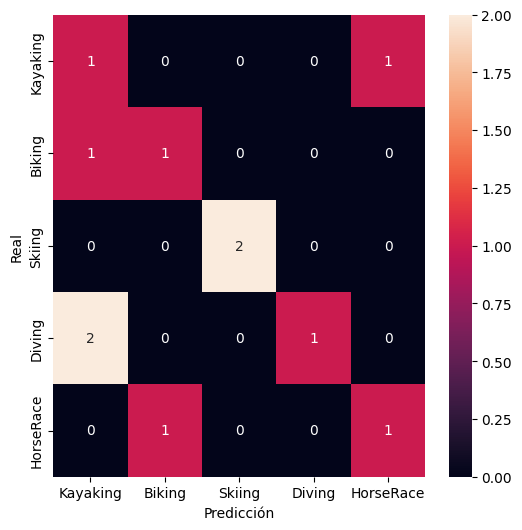

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for videos, labels in test_loader:
            videos, labels = videos.to(DEVICE), labels.to(DEVICE)
            outputs = model(videos)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    print("Clases en test set (y_true):", set(y_true))
    print("Clases en predicciones (y_pred):", set(y_pred))
    print(classification_report(y_true, y_pred, target_names=selected_videos.keys()))

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=selected_videos.keys(), yticklabels=selected_videos.keys())
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

# Evaluar el modelo
evaluate_model(model, test_loader)

## Inferencia

In [ ]:
def predict_video(model, video_path):
    model.eval()

    frames = extract_frames(video_path, num_frames=7)  # Convertir a blanco y negro
    frames = torch.tensor(frames, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    frames = frames.unsqueeze(0).to(DEVICE)  # Agregamos dimensión de batch

    with torch.no_grad():
        output = model(frames)
        pred_class = torch.argmax(output, dim=1).item()

    return list(selected_videos.keys())[pred_class]

# Prueba con un vídeo externo
video_path = "/content/drive/MyDrive/video_prueba.mp4"
print(f"Predicción: {predict_video(model, video_path)}")

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (4,2)  and requested shape (1,2)